In [ ]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [ ]:
def initialize_parameters_deep(layer_dims):
    """
    Initialize parameters for a deep neural network
    """
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2./layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

        # print(f"Initialization - Layer {l}:")
        # print(f"W{l} shape: {parameters['W' + str(l)].shape}")
        # print(f"b{l} shape: {parameters['b' + str(l)].shape}")

        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

    return parameters

In [ ]:
def linear_forward(A, W, b):
    """
    Implement forward propagation for a linear layer

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function
    cache -- a python tuple containing "A", "W" and "b" for computing backward pass efficiently
    """
    # Print shapes for debugging
    # print(f"Forward pass shapes:")
    # print(f"A shape: {A.shape}")
    # print(f"W shape: {W.shape}")
    # print(f"b shape: {b.shape}")

    # Compute Z = WA + b while ensuring proper broadcasting
    Z = np.dot(W, A) + b

    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)

    return Z, cache

In [ ]:
def sigmoid(Z):
    """
    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """

    A = 1/(1+np.exp(-Z))
    cache = Z

    return A, cache

def relu(Z):
  """
  Arguments:
  Z -- Output of the linear layer, of any shape

  Returns:
  A -- Post-activation parameter, of the same shape as Z
  cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
  """
  A = np.maximum(0,Z)

  assert(A.shape == Z.shape)

  cache = Z

  return A, cache

In [ ]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """

    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)

    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)

    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [ ]:
def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation.

    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep(), dictionary containing weights and biases

    Returns:
    AL -- last post-activation value (output layer)
    caches -- list of caches for each layer's linear and activation operations
    """

    if not parameters:  # Check if parameters is empty
        raise ValueError("Parameters dictionary is empty. Please initialize the model properly.")

    caches = []
    A = X
    L = len(parameters) // 2  # Number of layers in the neural network

    # Forward propagation through L-1 layers using ReLU activation
    for l in range(1, L):
        A_prev = A
        W = parameters.get(f'W{l}')
        b = parameters.get(f'b{l}')

        if W is None or b is None:
            raise ValueError(f"Missing parameters for layer {l}: W{l}, b{l}")

        A, cache = linear_activation_forward(A_prev, W, b, activation='relu')
        caches.append(cache)

    # Forward propagation through the final layer using Sigmoid activation
    W_final = parameters.get(f'W{L}')
    b_final = parameters.get(f'b{L}')

    if W_final is None or b_final is None:
        raise ValueError(f"Missing parameters for final layer {L}: W{L}, b{L}")

    AL, cache = linear_activation_forward(A, W_final, b_final, activation='sigmoid')
    caches.append(cache)

    # Debugging Information
    # print(f"Shape of AL: {AL.shape}")
    # print(f"Expected shape of AL: {(1, X.shape[1])}")

    # Ensure AL has the correct shape (1, number of examples)
    assert AL.shape == (1, X.shape[1]), f"AL shape mismatch: got {AL.shape}, expected {(1, X.shape[1])}"

    return AL, caches


In [ ]:
def compute_cost(AL, Y):
    """
    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """

    m = Y.shape[1]

    # Compute loss from aL and y.
    cost = (-1 / m) * np.sum(np.multiply(Y, np.log(AL)) + np.multiply(1 - Y, np.log(1 - AL)))

    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())

    return cost

In [ ]:
def linear_backward(dZ, cache):
    """
    Implements the linear portion of backward propagation for a single layer.

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1)
    dW -- Gradient of the cost with respect to W (current layer l)
    db -- Gradient of the cost with respect to b (current layer l)
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    # Compute gradients
    dW = (1/m) * np.dot(dZ, A_prev.T)
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    # Print shapes for debugging
    # print(f"dW shape: {dW.shape}")
    # print(f"db shape: {db.shape}")
    # print(f"dA_prev shape: {dA_prev.shape}")

    assert(dA_prev.shape == A_prev.shape)
    assert(dW.shape == W.shape)
    assert(db.shape == b.shape)

    return dA_prev, dW, db

In [ ]:
def relu_backward(dA, cache):
    """
    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0

    assert (dZ.shape == Z.shape)

    return dZ

def sigmoid_backward(dA, cache):
    """
    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """

    Z =cache
    dZ = dA * sigmoid(Z)[0] * (1 - sigmoid(Z)[0])

    assert (dZ.shape == Z.shape)

    return dZ

In [ ]:
def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.

    Arguments:
    dA -- post-activation gradient for current layer l
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache

    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)

    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)

    # Shorten the code
    dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db

In [ ]:
import numpy as np

def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group.

    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches:
                - caches[l] for ReLU layers (from 0 to L-2)
                - caches[L-1] for the sigmoid layer

    Returns:
    grads -- Dictionary containing gradients:
             - grads["dA" + str(l)]
             - grads["dW" + str(l)]
             - grads["db" + str(l)]
    """

    grads = {}
    L = len(caches)  # Number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)  # Ensure Y has the same shape as AL

    # Compute dAL (derivative of loss with respect to AL)
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    # Backpropagation for the last layer (SIGMOID -> LINEAR)
    current_cache = caches[-1]
    linear_cache, activation_cache = current_cache  # Unpacking cache
    dA_prev, dW, db = linear_backward(sigmoid_backward(dAL, activation_cache), linear_cache)

    grads["dA" + str(L)] = dA_prev
    grads["dW" + str(L)] = dW
    grads["db" + str(L)] = db

    # Loop through layers in reverse order (ReLU -> LINEAR)
    for l in reversed(range(L - 1)):
        current_cache = caches[l]
        linear_cache, activation_cache = current_cache  # Unpacking cache

        # Using relu_backward instead of sigmoid_backward
        dA_prev, dW, db = linear_backward(relu_backward(grads["dA" + str(l + 2)], activation_cache), linear_cache)

        grads["dA" + str(l + 1)] = dA_prev
        grads["dW" + str(l + 1)] = dW
        grads["db" + str(l + 1)] = db

    return grads


In [ ]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent

    Arguments:
    parameters -- python dictionary containing your parameters
    grads -- python dictionary containing your gradients, output of L_model_backward
    learning_rate -- learning rate of the gradient descent update rule

    Returns:
    parameters -- python dictionary containing your updated parameters
    """
    L = len(parameters) // 2  # number of layers in the neural network

    for l in range(L):
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]

        # Print shapes for debugging
        # print(f"Layer {l+1} updated shapes:")
        # print(f"W{l+1} shape: {parameters['W' + str(l + 1)].shape}")
        # print(f"b{l+1} shape: {parameters['b' + str(l + 1)].shape}")

    return parameters

In [ ]:
def L_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False): #lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.

    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps

    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    costs = []                         # keep track of cost

    # Parameters initialization.
    parameters = initialize_parameters_deep(layers_dims)

    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y)

        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)

        parameters = update_parameters(parameters, grads, learning_rate)

        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" % (i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return parameters

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline

!kaggle datasets download -d izznfkhrlislm/carnoncar-dataset
!unzip carnoncar-dataset.zip -d carnoncar-dataset

Dataset URL: https://www.kaggle.com/datasets/izznfkhrlislm/carnoncar-dataset
License(s): unknown
carnoncar-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  carnoncar-dataset.zip
replace carnoncar-dataset/car_scaled/car_scaled/car_scaled_1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


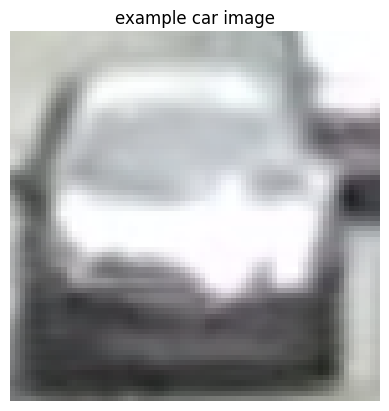

image dimension: (72, 72)


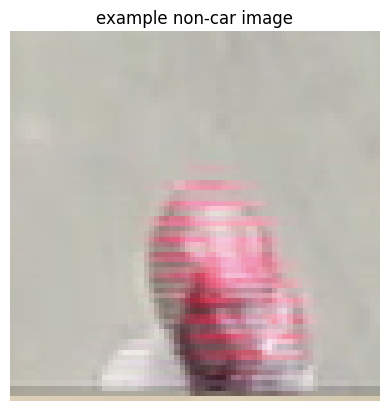

In [ ]:

car_dir = "carnoncar-dataset/car_scaled/car_scaled"
non_car_dir = "carnoncar-dataset/non_car_scaled/non_car_scaled"
# print some images
file_names = os.listdir(car_dir)
img_path = os.path.join(car_dir, file_names[4])
img = Image.open(img_path)
plt.figure()
plt.imshow(img)
plt.title(f"example car image")
plt.axis('off')
plt.show()
print(f"image dimension: {img.size}")
file_names = os.listdir(non_car_dir)
img_path = os.path.join(non_car_dir, file_names[0])
img = Image.open(img_path)
plt.figure()
plt.imshow(img)
plt.title(f"example non-car image")
plt.axis('off')
plt.show()


In [ ]:
car_dir = "carnoncar-dataset/car_scaled/car_scaled"
non_car_dir = "carnoncar-dataset/non_car_scaled/non_car_scaled"

# Function to load images and labels
def load_dataset(folder, label):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = Image.open(img_path)
        img_array = np.array(img)
        images.append(img_array)

    labels = [label] * len(images)

    return images, labels

# Load car and non-car images
car_images, car_labels = load_dataset(car_dir, 1)
non_car_images, non_car_labels = load_dataset(non_car_dir, 0)

# Combine and shuffle data
X = np.array(car_images + non_car_images)
Y = np.array(car_labels + non_car_labels)

# Shuffle dataset
m = X.shape[0]
indices = np.random.permutation(m)
X = X[indices]
Y = Y[indices]

# Split into train/test (80/20)
split = int(m * 0.8)
train_set_x_orig = X[:split]
train_set_y = Y[:split].reshape(1, -1)  # Shape (1, m_train)
test_set_x_orig = X[split:]
test_set_y = Y[split:].reshape(1, -1)   # Shape (1, m_test)

# Define classes
classes = ['non-car', 'car']

# Dataset statistics
m_train = train_set_y.shape[1]
m_test = test_set_y.shape[1]
num_px = train_set_x_orig.shape[1]  # Assuming square images

print(f"Training Examples: {m_train}")
print(f"Test Examples: {m_test}")
print(f"Image Dimensions: {num_px}x{num_px}")
print(f"Train Data Shape: {train_set_x_orig.shape}")
print(f"Train Labels Shape: {train_set_y.shape}")

# Flatten and normalize images
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

train_set_x = train_set_x_flatten / 255.0
test_set_x = test_set_x_flatten / 255.0

print("\nAfter preprocessing:")
print(f"Flattened Train Shape: {train_set_x.shape}")
print(f"Flattened Test Shape: {test_set_x.shape}")

Training Examples: 168
Test Examples: 43
Image Dimensions: 72x72
Train Data Shape: (168, 72, 72, 4)
Train Labels Shape: (1, 168)

After preprocessing:
Flattened Train Shape: (20736, 168)
Flattened Test Shape: (20736, 43)


Cost after iteration 0: 0.778421
Cost after iteration 100: 0.518267
Cost after iteration 200: 0.434899
Cost after iteration 300: 0.339246
Cost after iteration 400: 0.276031
Cost after iteration 500: 0.238244
Cost after iteration 600: 0.212531
Cost after iteration 700: 0.193837
Cost after iteration 800: 0.179571
Cost after iteration 900: 0.168062
Cost after iteration 1000: 0.158370
Cost after iteration 1100: 0.149913
Cost after iteration 1200: 0.142382
Cost after iteration 1300: 0.135603
Cost after iteration 1400: 0.129392
Cost after iteration 1500: 0.123647
Cost after iteration 1600: 0.118245
Cost after iteration 1700: 0.113145
Cost after iteration 1800: 0.108328
Cost after iteration 1900: 0.103753
Cost after iteration 2000: 0.099445
Cost after iteration 2100: 0.095350
Cost after iteration 2200: 0.091460
Cost after iteration 2300: 0.087790
Cost after iteration 2400: 0.084312
Cost after iteration 2500: 0.081022
Cost after iteration 2600: 0.077921
Cost after iteration 2700: 0.074979
Cost

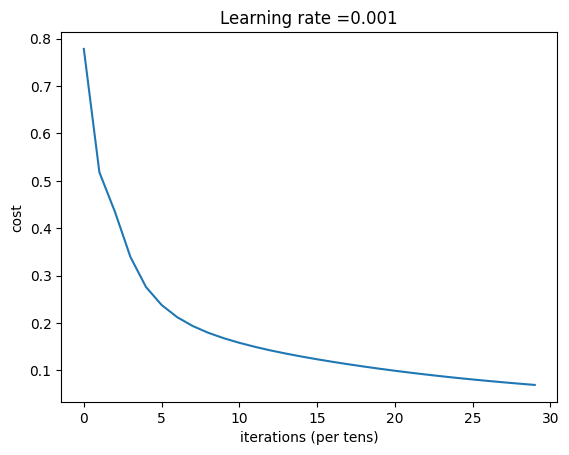

In [ ]:
# Define architecture
layers_dims = [20736, 20, 7, 1]  # your input dimension is 20736

# Train model
parameters = L_layer_model(train_set_x, train_set_y,
                         layers_dims,
                         learning_rate=0.001,
                         num_iterations=3000,
                         print_cost=True)

In [ ]:
# accuracy
def predict(X, parameters):
    """
    Predict whether the label is 0 or 1 using learned parameters.

    Arguments:
    X -- input data of shape (n_x, number of examples)
    parameters -- trained parameters of the model

    Returns:
    predictions -- vector of predictions of shape (1, number of examples)
    """
    # Forward propagation
    AL, _ = L_model_forward(X, parameters)

    # Convert probabilities to binary predictions
    predictions = (AL > 0.5).astype(int)

    return predictions

def compute_accuracy(predictions, Y):
    """
    Calculate accuracy of predictions compared to true labels.

    Arguments:
    predictions -- binary predictions (0/1)
    Y -- true labels

    Returns:
    accuracy -- accuracy as a percentage
    """
    accuracy = np.mean(predictions == Y) * 100
    return accuracy

# Make predictions on train and test sets
train_predictions = predict(train_set_x, parameters)
test_predictions = predict(test_set_x, parameters)

# Calculate accuracies
train_accuracy = compute_accuracy(train_predictions, train_set_y)
test_accuracy = compute_accuracy(test_predictions, test_set_y)

# Print results with detailed metrics
print("\nModel Evaluation Metrics:")
print("-" * 30)
print(f"Training Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Calculate confusion matrix for test set
test_cm = {
    'true_positive': np.sum((test_predictions == 1) & (test_set_y == 1)),
    'true_negative': np.sum((test_predictions == 0) & (test_set_y == 0)),
    'false_positive': np.sum((test_predictions == 1) & (test_set_y == 0)),
    'false_negative': np.sum((test_predictions == 0) & (test_set_y == 1))
}

# Print detailed metrics
print("\nDetailed Test Set Metrics:")
print("-" * 30)
print(f"True Positives: {test_cm['true_positive']}")
print(f"True Negatives: {test_cm['true_negative']}")
print(f"False Positives: {test_cm['false_positive']}")
print(f"False Negatives: {test_cm['false_negative']}")

# Calculate precision, recall, and F1 score
precision = test_cm['true_positive'] / (test_cm['true_positive'] + test_cm['false_positive'])
recall = test_cm['true_positive'] / (test_cm['true_positive'] + test_cm['false_negative'])
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"\nPrecision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")





Model Evaluation Metrics:
------------------------------
Training Accuracy: 98.81%
Test Accuracy: 95.35%

Detailed Test Set Metrics:
------------------------------
True Positives: 19
True Negatives: 22
False Positives: 0
False Negatives: 2

Precision: 1.00
Recall: 0.90
F1 Score: 0.95


In [ ]:
from ctypes import sizeof
import pickle
def sigmoid(Z):
    """
    Compute sigmoid of Z
    """
    return 1/(1 + np.exp(-Z))

def save_parameters(parameters, filename='parameters.pkl'):
    """
    Save the model parameters in the correct format
    """
    # Save all layers instead of just the first one
    p = {
        "parameters": parameters  # Save the complete parameters dictionary
    }

    with open(filename, 'wb') as f:
        pickle.dump(p, f)
    print(f"Parameters saved to {filename}")

def predict_from_png(image_path, p):
    """
    Predict whether an image contains a car using the full neural network

    Arguments:
    image_path -- path to the image
    p -- dictionary containing the neural network parameters
    """
    try:
        # Load and preprocess image
        img = Image.open(image_path)
        img = img.resize((72, 72))  # Match the original training image size
        img_array = np.array(img)
        print(len(img_array))


        # Normalize and reshape
        img_array = img_array / 255.0
        img_flatten = img_array.reshape(-1, 1)  # Flatten to (n_x, 1)

        # Get the full set of parameters
        parameters = p["parameters"]

        # Forward propagation through the network
        A = img_flatten
        L = len(parameters) // 2

        # Use the same forward propagation as in training
        for l in range(1, L):
            W = parameters[f'W{l}']
            b = parameters[f'b{l}']
            Z = np.dot(W, A) + b
            A = np.maximum(0, Z)  # ReLU activation

        # Final layer with sigmoid
        W = parameters[f'W{L}']
        b = parameters[f'b{L}']
        Z = np.dot(W, A) + b
        Y_prediction = sigmoid(Z)

        # Visualization
        plt.figure(figsize=(10, 6))
        plt.imshow(img)
        plt.axis('off')

        isCar = Y_prediction > 0.5
        Pred_Probability = Y_prediction[0][0] * 100

        prediction_text = "Prediction: Car" if isCar else "Prediction: Not a Car"
        probability_text = f"Probability: {Pred_Probability:.2f}%"

        plt.text(10, 20, prediction_text, color='white',
                fontsize=12, fontweight='bold',
                bbox=dict(facecolor='green' if isCar else 'red', alpha=0.7))
        plt.text(10, 50, probability_text, color='white',
                fontsize=10,
                bbox=dict(facecolor='black', alpha=0.7))

        plt.show()

    except Exception as e:
        print(f"Error processing image: {str(e)}")
        raise

In [ ]:
# First save the parameters
save_parameters(parameters)

# Load saved parameters
with open('parameters.pkl', 'rb') as f:
    loaded_parameters = pickle.load(f)


Parameters saved to parameters.pkl


72


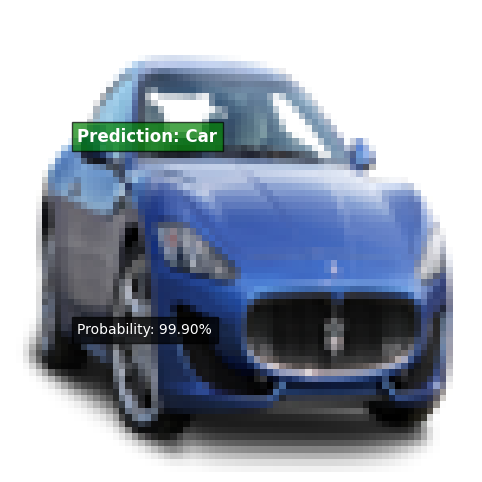

In [ ]:
# Make predictions
predict_from_png("/content/car.png", loaded_parameters)